# Amazon Comprehend PII Detection and Redaction

Amazon Comprehend can be used to perform pii detection and redaction. You can accurately analyze customer interactions, including social media posts, reviews, customer interaction transcripts to improve your products and services.



This lab includes step-by-step instructions for performing PII detection and redaction using Amazon Comprehend.

The lab is divided into 2 different section

* PII detection and redaction for text 
* PII detection and redaction for images


Depending on the usecase, we will be using different AWS service to achieve this. 

### PII detection and redaction  using Comprehend Process and summary
You can use Amazon Comprehend to detect entities in your text that contain personally identifiable information (PII), or PII entities. A PII entity is a textual reference to personal data that could be used to identify an individual, such as an address, bank account number, or phone number.

For example, you can detect the PII entities in the following text by submitting it to Amazon Comprehend:

Hello Paulo Santos. The latest statement for your credit card account 1111-0000-1111-0000 was mailed to 123 Any Street, Seattle, WA 98109.

When Amazon Comprehend completes its analysis, it returns output that either locates or redacts the PII entities in the text.

For example, if you choose to locate the PII entities, the output includes the character offsets for each one, along with the entity type and other details. In this case, the output states that "Paul Santos" has the type NAME, "1111-0000-1111-0000" has the type CREDIT_DEBIT_NUMBER, and "123 Any Street, Seattle, WA 98109" has the type ADDRESS.

Alternatively, if you choose to redact the PII entities, Amazon Comprehend returns a copy of the input text in which each PII entity is redacted:

Hello ***** ******. The latest statement for your credit card account ******************* was mailed to *** *** ******* ******** ** *****.

You can detect PII entities with both real-time synchronous operations and batch asynchronous jobs. However, you must use an asynchronous job if you want to produce output with redacted PII entities.

You can use the following operations to detect PII entities in a document or set of documents:

   * DetectPiiEntities

   * StartPiiEntitiesDetectionJob



## Setup

Let's start by specifying:

* AWS region.
* The IAM role arn used to give access to Comprehend API and S3 bucket.
* The S3 bucket that you want to use for training and model data.


In [1]:

import os
import boto3
import re
import json
import sagemaker
from sagemaker import get_execution_role

region = boto3.Session().region_name

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

In [2]:
prefix = "sagemaker/pii-detection-redaction"
bucket_path = "https://s3-{}.amazonaws.com/{}".format(region, bucket)
# Customize to your bucket where you have stored the data
print(bucket_path)

https://s3-us-east-1.amazonaws.com/sagemaker-us-east-1-348052051973


## PII detection and redaction for text 
In this section we will be performing PII detection and redaction for text. 

### Data 
Lets begin by uploading the data in the S3 bucket

In [3]:
import boto3

s3 = boto3.resource('s3')


s3.Bucket(bucket).upload_file("pii-test-data.csv", "sagemaker/pii-detection-redaction/pii-test-data.csv")


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)




Now lets read this into a Pandas data frame and take a look.


In [4]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd 

data = pd.read_csv('pii-test-data.csv')   

data

Hello, My name is Smith Jackson and my address is 10932 Bigge Rd,Menlo Park,CA,94025
0  Hello, I m Ashley Smith and my phone number is...                                  
1   My credit card number is 5370-4638-8881-3020,713                                  
2   For verification purposes, my SSN is 172-32-1176                                  
3  Please send me the receipt on my email address...                                  
4  I do not wish to subscribe to your marketing m...                                  
5  Good morning, everybody. My name is Van Bokhor...                                  
6  Please  send the service man to this address 2...                                  
7  In case of any issues please call at this numb...                                  
8  Here are my contact details: Call me 751-01-23...



### We will use detect_pii_entities API

This API will inspects the input text for entities that contain personally identifiable information (PII) and returns information about them. 
Steps:
* Use boto3 to initialize the comprehend client
* Define the sample text 
* Called the detect_pii_entities API and pass in the text as the input parameter. 

In [5]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend', region_name=region)
                
text = "Here are my contact details: Call me 751-01-2327 or email me at lvenson@domain.com"

print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_pii_entities(Text=text, LanguageCode='en')))
print('End of DetectSentiment\n')


Calling DetectSentiment
{"Entities": [{"Score": 0.9999926090240479, "Type": "PHONE", "BeginOffset": 37, "EndOffset": 48}, {"Score": 0.9999990463256836, "Type": "EMAIL", "BeginOffset": 64, "EndOffset": 82}], "ResponseMetadata": {"RequestId": "e3c73150-51bb-48f7-b7e0-62ee94d63a35", "HTTPStatusCode": 200, "HTTPHeaders": {"x-amzn-requestid": "e3c73150-51bb-48f7-b7e0-62ee94d63a35", "content-type": "application/x-amz-json-1.1", "content-length": "166", "date": "Thu, 26 May 2022 03:31:33 GMT"}, "RetryAttempts": 0}}
End of DetectSentiment



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


### We will use StartPiiEntitiesDetectionJob API

StartPiiEntitiesDetectionJob API starts an asynchronous PII entity detection job for a collection of documents.

We would be using this API to perform pii detection and redaction for pii-test-data.csv which we had inspected above. 

In [6]:
import uuid
InputS3URI= "s3://"+bucket+ "/sagemaker/pii-detection-redaction/pii-test-data.csv"
print(InputS3URI)
OutputS3URI="s3://"+bucket+"/sagemaker/pii-detection-redaction"
print(OutputS3URI)
job_uuid = uuid.uuid1()
job_name = f"pii-job-{job_uuid}"

s3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/pii-test-data.csv
s3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction


In [13]:
InputS3URI: "s3://"+bucket+ "sagemaker/pii-detection-redaction/pii-test-data.csv"
response = comprehend.start_pii_entities_detection_job(
    InputDataConfig={
        'S3Uri': InputS3URI,
        'InputFormat': 'ONE_DOC_PER_FILE'
    },
    OutputDataConfig={
        'S3Uri': OutputS3URI
       
    },
    Mode='ONLY_REDACTION',
    RedactionConfig={
        'PiiEntityTypes': [
           'ALL',
        ],
        'MaskMode': 'MASK',
        'MaskCharacter': '*'
    },
    DataAccessRoleArn = 'arn:aws:iam::348052051973:role/service-role/AmazonComprehendServiceRoleS3FullAccess-ComprehendLabs',
    JobName=job_name,
    LanguageCode='en',
    
)


In [14]:
# Get the job ID
events_job_id = response['JobId']
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)

{'PiiEntitiesDetectionJobProperties': {'JobId': '68ab07395c829807367300ff8af678d8', 'JobArn': 'arn:aws:comprehend:us-east-1:348052051973:pii-entities-detection-job/68ab07395c829807367300ff8af678d8', 'JobName': 'pii-job-5a9b17d8-dca4-11ec-b2a1-0a34d7217347', 'JobStatus': 'IN_PROGRESS', 'SubmitTime': datetime.datetime(2022, 5, 26, 5, 18, 27, 909000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/pii-test-data.csv', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/348052051973-PII-68ab07395c829807367300ff8af678d8/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::348052051973:role/service-role/AmazonComprehendServiceRoleS3FullAccess-ComprehendLabs', 'Mode': 'ONLY_REDACTION'}, 'ResponseMetadata': {'RequestId': 'f97c4e4a-a23

The job will take roughly 6-7 minutes. The below code is to check the status of the job. The cell execution would be completed after the job is completed 

In [16]:
from time import sleep
# Get current job status
job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)
print(job)
# Loop until job is completed
waited = 0
timeout_minutes = 10
while job['PiiEntitiesDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    job = comprehend.describe_pii_entities_detection_job(JobId=events_job_id)

{'PiiEntitiesDetectionJobProperties': {'JobId': '68ab07395c829807367300ff8af678d8', 'JobArn': 'arn:aws:comprehend:us-east-1:348052051973:pii-entities-detection-job/68ab07395c829807367300ff8af678d8', 'JobName': 'pii-job-5a9b17d8-dca4-11ec-b2a1-0a34d7217347', 'JobStatus': 'COMPLETED', 'SubmitTime': datetime.datetime(2022, 5, 26, 5, 18, 27, 909000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2022, 5, 26, 5, 24, 34, 736000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/pii-test-data.csv', 'InputFormat': 'ONE_DOC_PER_FILE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/348052051973-PII-68ab07395c829807367300ff8af678d8/output/'}, 'RedactionConfig': {'PiiEntityTypes': ['ALL'], 'MaskMode': 'MASK', 'MaskCharacter': '*'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::348052051973:role/service-role/AmazonComprehendServiceRoleS3FullAccess-ComprehendLab

In [17]:
print(response)

{'JobId': '68ab07395c829807367300ff8af678d8', 'JobArn': 'arn:aws:comprehend:us-east-1:348052051973:pii-entities-detection-job/68ab07395c829807367300ff8af678d8', 'JobStatus': 'SUBMITTED', 'ResponseMetadata': {'RequestId': '990d068f-ccae-4240-888e-7fc8b732caa1', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '990d068f-ccae-4240-888e-7fc8b732caa1', 'content-type': 'application/x-amz-json-1.1', 'content-length': '181', 'date': 'Thu, 26 May 2022 05:18:27 GMT'}, 'RetryAttempts': 0}}


In [18]:
filename="pii-test-data.csv"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
print(output_data_s3_file)

s3://sagemaker-us-east-1-348052051973/sagemaker/pii-detection-redaction/348052051973-PII-68ab07395c829807367300ff8af678d8/output/pii-test-data.csv.out


Now lets use the API for our sample dataset and check the response 

In [19]:
import boto3

from io import BytesIO

session = boto3.Session()
s3_client = session.client("s3")

# The output filename is the input filename + ".out"

filename="pii-test-data.csv"
output_data_s3_file = job['PiiEntitiesDetectionJobProperties']['OutputDataConfig']['S3Uri'] + filename + '.out'
output_data_s3_filepath=output_data_s3_file.split("//")[1].split("/")[1]+"/"+output_data_s3_file.split("//")[1].split("/")[2]+"/"+output_data_s3_file.split("//")[1].split("/")[3]+"/"+output_data_s3_file.split("//")[1].split("/")[4]+"/"+output_data_s3_file.split("//")[1].split("/")[5]
print(output_data_s3_filepath)

f = BytesIO()
s3_client.download_fileobj(bucket, output_data_s3_filepath, f)
f.seek(0)
print(f.getvalue())


sagemaker/pii-detection-redaction/348052051973-PII-68ab07395c829807367300ff8af678d8/output/pii-test-data.csv.out
b'\xef\xbb\xbf"Hello, My name ** ************* and my address *************************************"\r\n"Hello, I ************** and my phone number ** ************"\r\n"My credit card number ** ***********************"\r\n"For verification purposes, my SSN **************"\r\nPlease send me the receipt on my email ******* *****************\r\n"I do not wish to subscribe to your marketing messages, please unsubscribe me "\r\n"Good morning, everybody. My name **********************, and today I feel like sharing a whole lot of personal information with you. Let\'s start with my Email ******* ****************************. My address *****************************************. My phone number ***************. My Social security number **************. My Bank account number ** ************ and routing ****************. My credit card number ** ****************,my *** ******. Well,

## PII Detection and Redaction in Images

In this lab, we will be performing extracting the text from the images using AWS Rekognition and then use Comprehend to perform pii detection. Then we will be using python function to redact that portion of the image.  Here is conceptual architectural flow:

![alt-text](piiredaction.jpg)

You can automate the entire end to end flow using step function and lambda for orchestration.

### Driver's License 

We will first take an example of driver's license image. 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


(1080, 1920, 4)


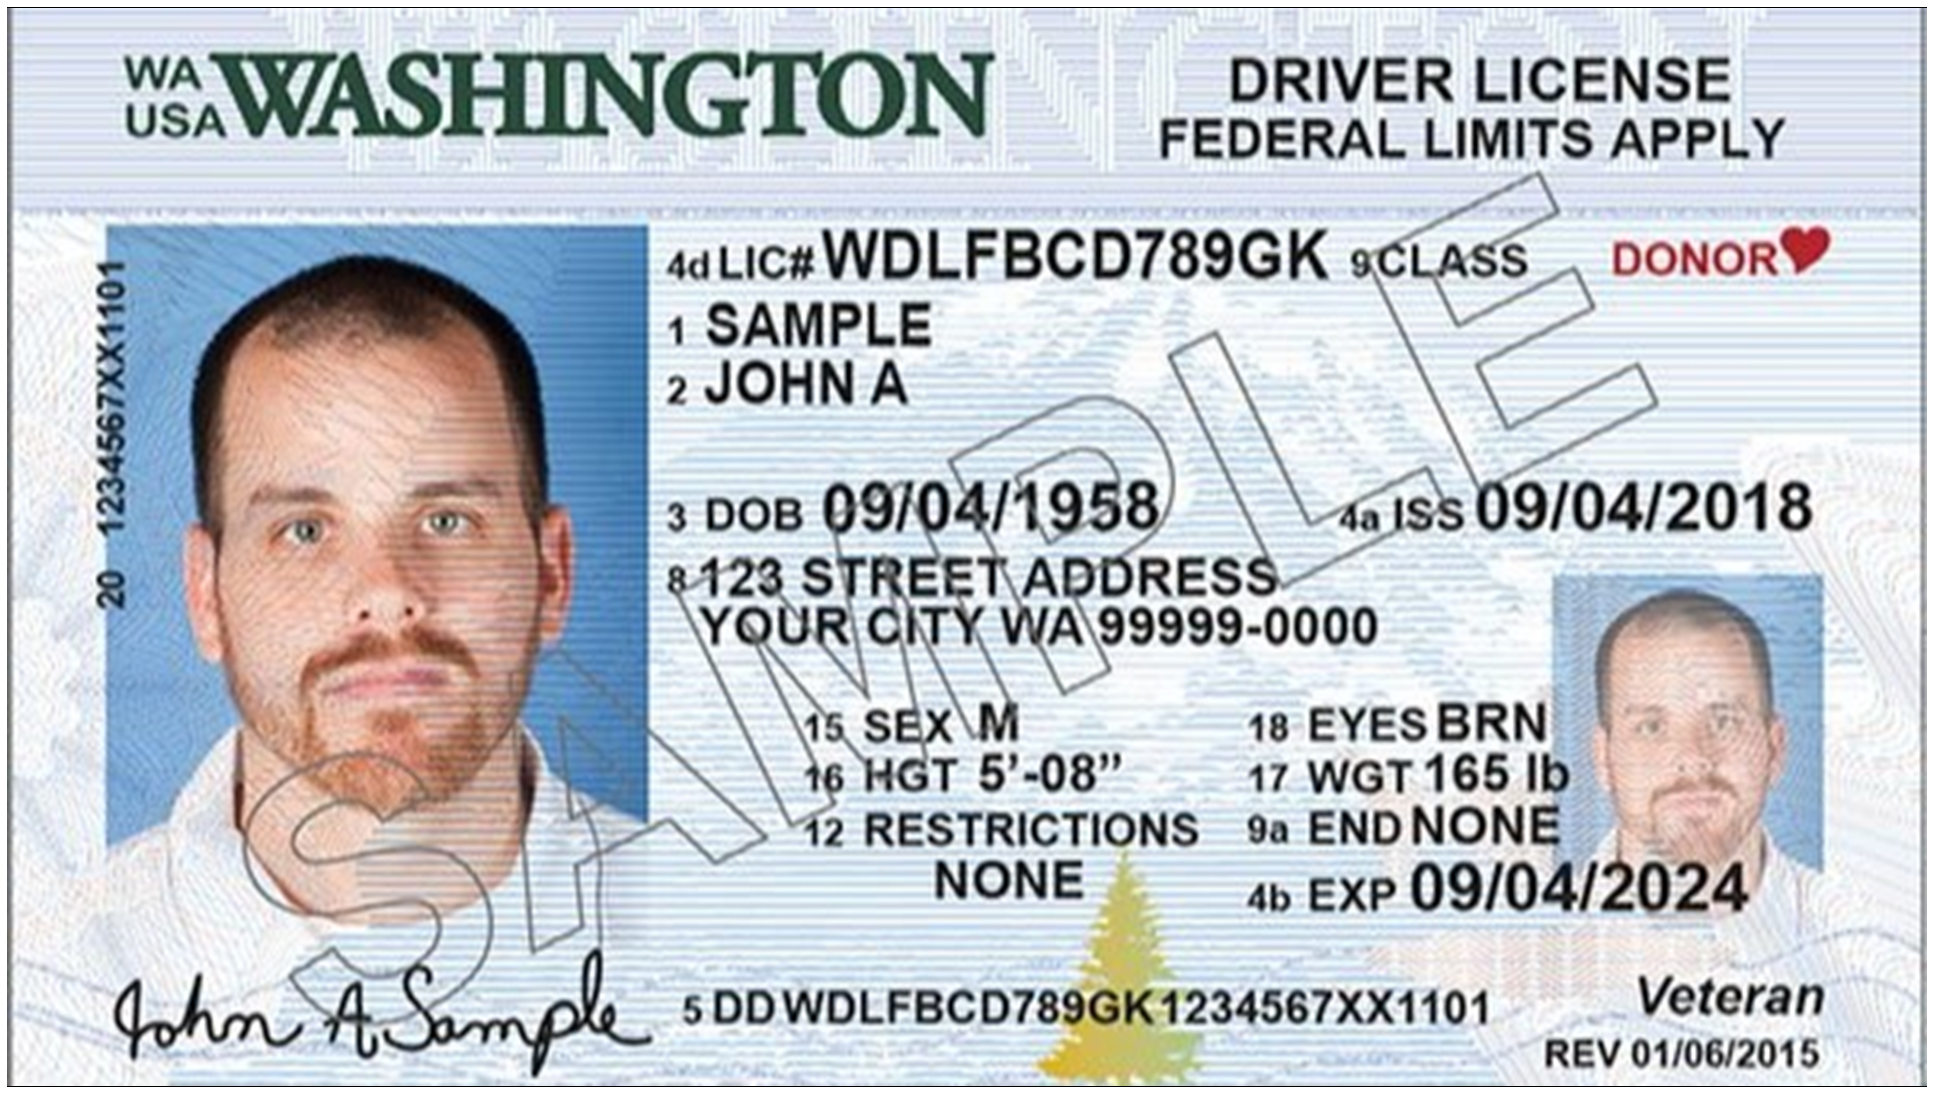

In [20]:
s3.Bucket(bucket).upload_file("wa-license.png", "sagemaker/pii-detection-redaction/wa-license.png")

object='sagemaker/pii-detection-redaction/wa-license.png'

redacted_box_color='red'
dpi = 72
pii_detection_threshold = 0.00


# If the image is in DICOM format, convert it to PNG
if (object.split(".")[-1:][0] == "dcm"):
    ! aws s3 cp s3://{bucket}/{object} .
    ! convert -format png {object.split("/")[-1:][0]} {object.split("/")[-1:][0]}.png
    ! aws s3 cp {object.split("/")[-1:][0]}.png s3://{bucket}/{object}.png
    object=object+'.png'
    print(object)

# Import all of the required libraries
%matplotlib inline
import boto3
import json
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib as mpl
from imageio import imread

import base64
# Import cStringIO



# Implement AWS Services
rekognition=boto3.client('rekognition')
comprehend = boto3.client(service_name='comprehend')
s3=boto3.resource('s3')

# Download the image from S3 and hold it in memory
img_bucket = s3.Bucket(bucket)
img_object = img_bucket.Object(object)
xray = io.BytesIO()
img_object.download_fileobj(xray)
img = np.array(Image.open(xray), dtype=np.uint8)
print(img.shape)
# Set the image color map to grayscale, turn off axis grapiing, and display the image
height, width,channel = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
# Display the image.
ax.imshow(img, cmap='gray')
plt.show()

In [21]:
# Use Amazon Rekognition to detect all of the text in the image

response=rekognition.detect_text(Image={'Bytes':xray.getvalue()})
textDetections=response['TextDetections']
print ('Aggregating detected text...')
textblock=""
offsetarray=[]
totallength=0

#The various text detections are returned in a JSON object.  Aggregate the text into a single large block and
#keep track of the offsets.  This will allow us to make a single call to Amazon Comprehend   for
#pii detection and minimize our Comprehend   service charges.
for text in textDetections:
    if text['Type'] == "LINE":
            offsetarray.append(totallength)
            totallength+=len(text['DetectedText'])+1
            textblock=textblock+text['DetectedText']+" "  
            print ("adding '"+text['DetectedText']+"', length: "+str(len(text['DetectedText']))+", offsetarray: "+str(offsetarray))
offsetarray.append(totallength)
totaloffsets=len(offsetarray)

Aggregating detected text...
adding 'WA USA WASHINGTON', length: 17, offsetarray: [0]
adding 'DRIVER LICENSE', length: 14, offsetarray: [0, 18]
adding 'FEDERAL LIMITS APPLY', length: 20, offsetarray: [0, 18, 33]
adding '4d LIC# WDLFBCD789GK 9CLASS', length: 27, offsetarray: [0, 18, 33, 54]
adding 'DONOR', length: 5, offsetarray: [0, 18, 33, 54, 82]
adding '1 SAMPLE', length: 8, offsetarray: [0, 18, 33, 54, 82, 88]
adding '2 JOHN A', length: 8, offsetarray: [0, 18, 33, 54, 82, 88, 97]
adding '3 DOB 09/04/1958', length: 16, offsetarray: [0, 18, 33, 54, 82, 88, 97, 106]
adding '4a ISS 09/04/2018', length: 17, offsetarray: [0, 18, 33, 54, 82, 88, 97, 106, 123]
adding '8123 STREET ADDRESS', length: 19, offsetarray: [0, 18, 33, 54, 82, 88, 97, 106, 123, 141]
adding '20 1234567XX1101', length: 16, offsetarray: [0, 18, 33, 54, 82, 88, 97, 106, 123, 141, 161]
adding 'YOUR CITY WA 99999-0000', length: 23, offsetarray: [0, 18, 33, 54, 82, 88, 97, 106, 123, 141, 161, 178]
adding '18 EYES BRN', len

In [22]:
# Call Amazon Comprehend   and pass it the aggregated text from our   image.
pii_boxes_list=[]
piilist=comprehend.detect_pii_entities(Text = textblock, LanguageCode='en')

#Amazon Comprehend   will return a JSON object that contains all of the pii detected in the text block with
#offset values that describe where the pii begins and ends.  We can use this to determine which of the text blocks 
#detected by Amazon Rekognition should be redacted.  The 'pii_boxes_list' list is created to keep track of the
#bounding boxes that potentially contain pii.
print ('Finding PII text...')
not_redacted=0
for pii in piilist['Entities']:
    print(pii['Type'])
    if pii['Score'] > pii_detection_threshold:
        for i in range(0,totaloffsets-1):
            if offsetarray[i] <= pii['BeginOffset'] < offsetarray[i+1]:
                if textDetections[i]['Geometry']['BoundingBox'] not in pii_boxes_list:
                    print ("detected as type '"+pii['Type']+"' and will be redacted.")
                    print(i)
                    pii_boxes_list.append(textDetections[i]['Geometry']['BoundingBox'])
    else:
        print (" was detected as type '"+pii['Type']+"', but did not meet the confidence score threshold and will not be redacted.")
        not_redacted+=1
pii_boxes_list.append(textDetections[3]['Geometry']['BoundingBox'])
pii_boxes_list.append(textDetections[4]['Geometry']['BoundingBox'])
pii_boxes_list.append(textDetections[10]['Geometry']['BoundingBox'])

print ("Found", len(pii_boxes_list), "text boxes to redact.")
print (not_redacted, "additional text boxes were detected, but did not meet the confidence score threshold.")

Finding PII text...
ADDRESS
detected as type 'ADDRESS' and will be redacted.
0
ADDRESS
DRIVER_ID
detected as type 'DRIVER_ID' and will be redacted.
3
NAME
detected as type 'NAME' and will be redacted.
6
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
7
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
8
ADDRESS
detected as type 'ADDRESS' and will be redacted.
9
ADDRESS
detected as type 'ADDRESS' and will be redacted.
10
ADDRESS
detected as type 'ADDRESS' and will be redacted.
11
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
14
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
19
NAME
detected as type 'NAME' and will be redacted.
20
INTERNATIONAL_BANK_ACCOUNT_NUMBER
detected as type 'INTERNATIONAL_BANK_ACCOUNT_NUMBER' and will be redacted.
22
DATE_TIME
detected as type 'DATE_TIME' and will be redacted.
24
Found 16 text boxes to redact.
0 additional text boxes were detected, but did not meet the confidence score threshold.


s3.Object(bucket_name='sagemaker-us-east-1-348052051973', key='redacted/sagemaker/pii-detection-redaction/wa-license.png')

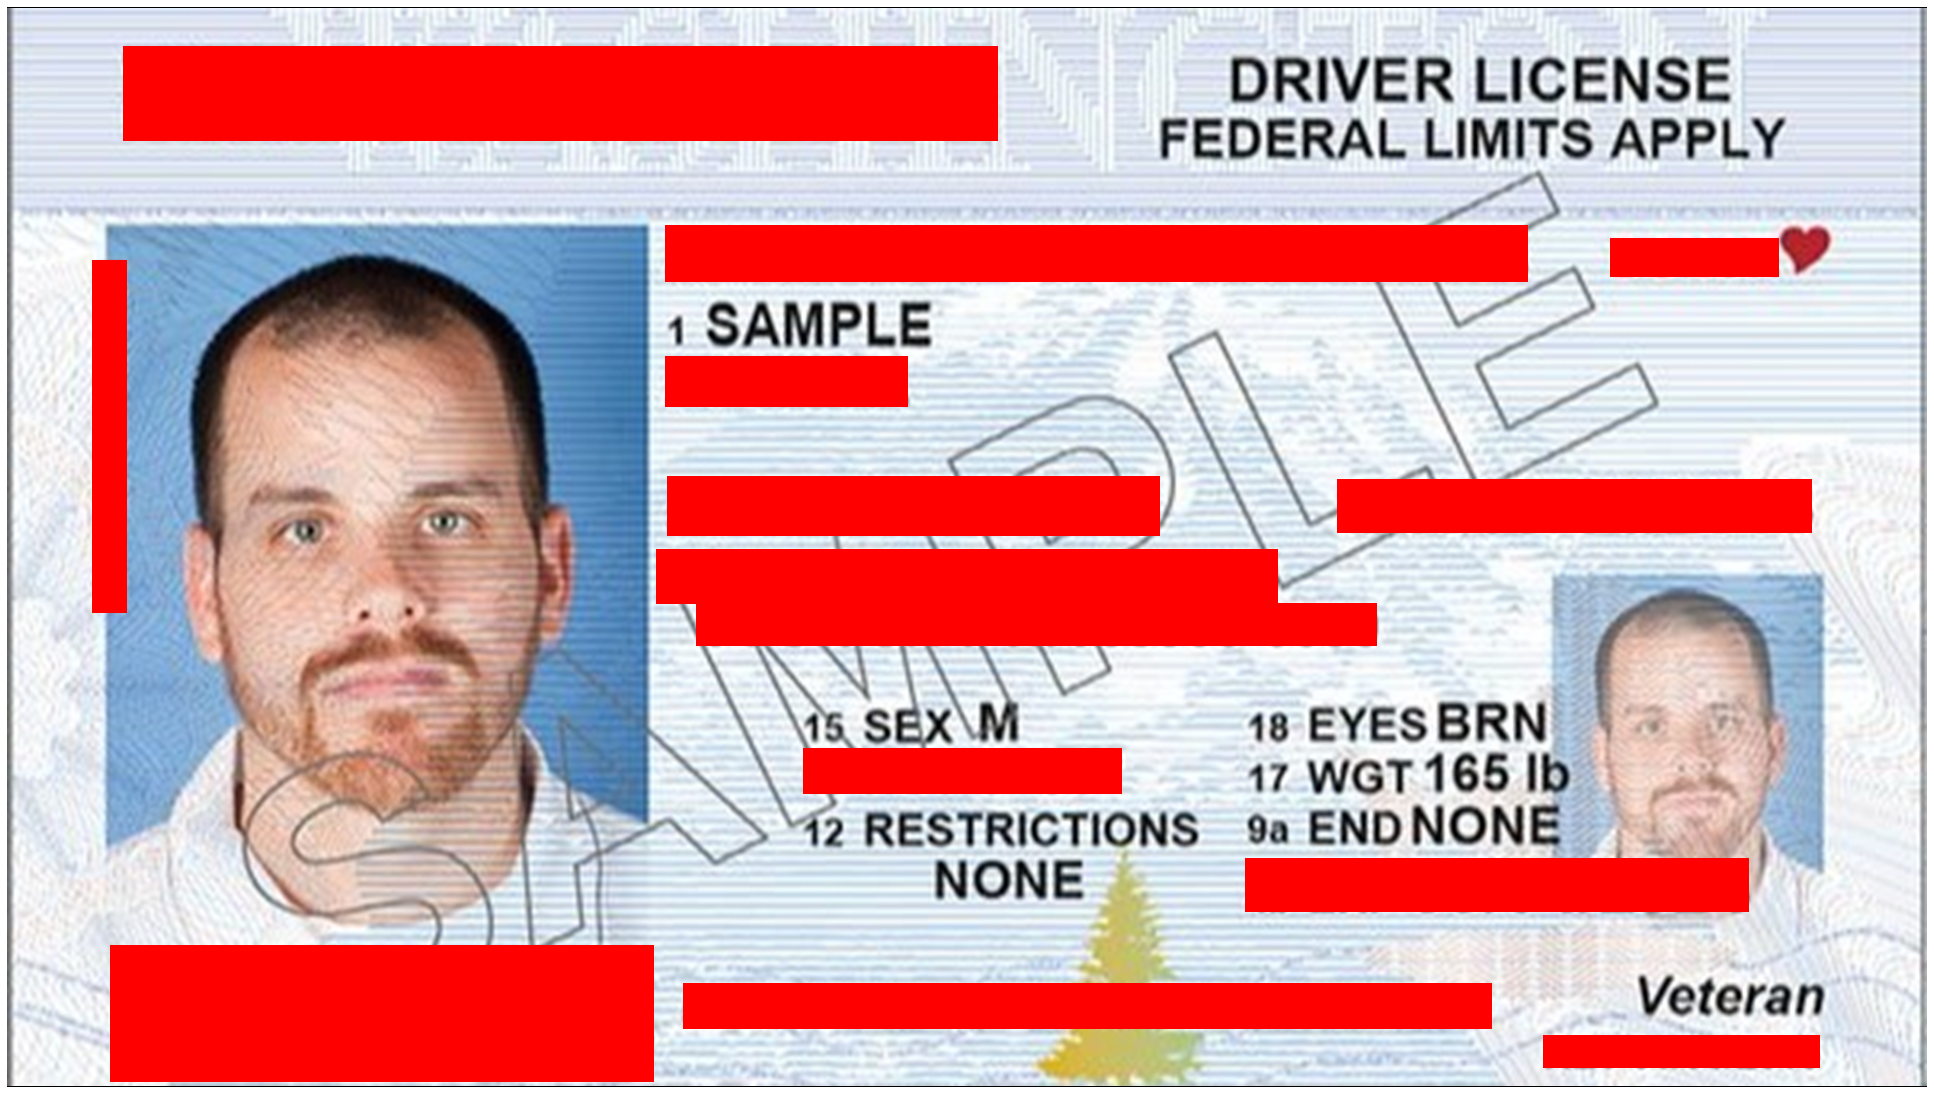

In [23]:
# Now this list of bounding boxes will be used to draw red boxes over the pii text.
height, width, channel = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img)
plt.imshow(img, cmap='gray')
for box in pii_boxes_list:
    #The bounding boxes are described as a ratio of the overall image dimensions, so we must multiply them
    #by the total image dimensions to get the exact pixel values for each dimension.
    x = img.shape[1] * box['Left']
    y = img.shape[0] * box['Top']
    width = img.shape[1] * box['Width']
    height = img.shape[0] * box['Height']
    rect = patches.Rectangle((x,y),width,height,linewidth=0,edgecolor=redacted_box_color,facecolor=redacted_box_color)
    ax.add_patch(rect)
# Ensure that no axis or whitespaces is printed in the image file we want to save.
plt.axis('off')    
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save redacted   image to the same Amazon S3 bucket, in PNG format, with 'de-id-' in front of the original filename.
img_data = io.BytesIO()
plt.savefig(img_data, bbox_inches='tight', pad_inches=0, format='png')
img_data.seek(0)
# Write the redacted image to S3
#object='sagemaker/pii-detection-redaction/wa-license.png'
img_bucket.put_object(Body=img_data, ContentType='image/png', Key="redacted/"+object)

### PII redaction from passport image

Similar to above usecase, we will be performing PII redaction for the passport image


In [ ]:
s3.Bucket(bucket).upload_file("samplepassport.png", "sagemaker/pii-detection-redaction/samplepassport.png")

object='sagemaker/pii-detection-redaction/samplepassport.png'


redacted_box_color='red'
dpi = 72
pii_detection_threshold = 0.00


# If the image is in DICOM format, convert it to PNG
if (object.split(".")[-1:][0] == "dcm"):
    ! aws s3 cp s3://{bucket}/{object} .
    ! convert -format png {object.split("/")[-1:][0]} {object.split("/")[-1:][0]}.png
    ! aws s3 cp {object.split("/")[-1:][0]}.png s3://{bucket}/{object}.png
    object=object+'.png'
    print(object)

# Import all of the required libraries
%matplotlib inline
import boto3
import json
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import matplotlib as mpl
from imageio import imread

import base64
#import cStringIO



#Implement AWS Services
rekognition=boto3.client('rekognition')
comprehend = boto3.client(service_name='comprehend')
s3=boto3.resource('s3')

#Download the image from S3 and hold it in memory
img_bucket = s3.Bucket(bucket)
img_object = img_bucket.Object(object)
xray = io.BytesIO()
img_object.download_fileobj(xray)
img = np.array(Image.open(xray), dtype=np.uint8)
print(img.shape)
#Set the image color map to grayscale, turn off axis grapiing, and display the image
height, width,channel = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
# Hide spines, ticks, etc.
ax.axis('off')
# Display the image.
ax.imshow(img, cmap='gray')
plt.show()

In [ ]:
# Use Amazon Rekognition to detect all of the text in the   image
#response=rekognition.detect_text(Image={'S3Object':{'Bucket':bucket,'Name':object}})
response=rekognition.detect_text(Image={'Bytes':xray.getvalue()})
textDetections=response['TextDetections']
print ('Aggregating detected text...')
textblock=""
offsetarray=[]
totallength=0

# The various text detections are returned in a JSON object.  Aggregate the text into a single large block and
# keep track of the offsets.  This will allow us to make a single call to Amazon Comprehend   for
# pii detection and minimize our Comprehend   service charges.
for text in textDetections:
    if text['Type'] == "LINE":
            offsetarray.append(totallength)
            totallength+=len(text['DetectedText'])+1
            textblock=textblock+text['DetectedText']+" "  
            print ("adding '"+text['DetectedText']+"', length: "+str(len(text['DetectedText']))+", offsetarray: "+str(offsetarray))
offsetarray.append(totallength)
totaloffsets=len(offsetarray)

In [ ]:
# Call Amazon Comprehend  and pass it the aggregated text from our  image.
pii_boxes_list=[]
piilist=comprehend.detect_pii_entities(Text = textblock, LanguageCode='en')

#Amazon Comprehend  will return a JSON object that contains all of the PII detected in the text block with
#offset values that describe where the PII begins and ends.  We can use this to determine which of the text blocks 
#detected by Amazon Rekognition should be redacted.  The 'pii_boxes_list' list is created to keep track of the
#bounding boxes that potentially contain PII.
print ('Finding PII text...')
not_redacted=0
for pii in piilist['Entities']:
    print(pii['Type'])
    if pii['Score'] > pii_detection_threshold:
        for i in range(0,totaloffsets-1):
            if offsetarray[i] <= pii['BeginOffset'] < offsetarray[i+1]:
                if textDetections[i]['Geometry']['BoundingBox'] not in pii_boxes_list:
                    print ("detected as type '"+pii['Type']+"' and will be redacted.")
                    print(i)
                    pii_boxes_list.append(textDetections[i]['Geometry']['BoundingBox'])
    else:
        print (" was detected as type '"+pii['Type']+"', but did not meet the confidence score threshold and will not be redacted.")
        not_redacted+=1
pii_boxes_list.append(textDetections[4]['Geometry']['BoundingBox'])
pii_boxes_list.append(textDetections[5]['Geometry']['BoundingBox'])
pii_boxes_list.append(textDetections[8]['Geometry']['BoundingBox'])
pii_boxes_list.append(textDetections[6]['Geometry']['BoundingBox'])

print ("Found", len(pii_boxes_list), "text boxes to redact.")
pii_boxes_list.append(textDetections[9]['Geometry']['BoundingBox'])
print (not_redacted, "additional text boxes were detected, but did not meet the confidence score threshold.")

In [ ]:
# This list of bounding boxes will be used to draw red boxes over the PII text.
height, width, channel = img.shape
# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)
# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img)
plt.imshow(img, cmap='gray')
for box in pii_boxes_list:
    #The bounding boxes are described as a ratio of the overall image dimensions, so we must multiply them
    #by the total image dimensions to get the exact pixel values for each dimension.
    x = img.shape[1] * box['Left']
    y = img.shape[0] * box['Top']
    width = img.shape[1] * box['Width']
    height = img.shape[0] * box['Height']
    rect = patches.Rectangle((x,y),width,height,linewidth=0,edgecolor=redacted_box_color,facecolor=redacted_box_color)
    ax.add_patch(rect)
#Ensure that no axis or whitespaces is printed in the image file we want to save.
plt.axis('off')    
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#Save redacted image to the same Amazon S3 bucket, in PNG format, with 'de-id-' in front of the original filename.
img_data = io.BytesIO()
plt.savefig(img_data, bbox_inches='tight', pad_inches=0, format='png')
img_data.seek(0)
#Write the redacted image to S3
img_bucket.put_object(Body=img_data, ContentType='image/png',  Key="redacted/"+object)